## Install Packages

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 44.3 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from google.colab import drive

workers = 0 if os.name == 'nt' else 2

In [ ]:
# mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Fetch data from Google Drive
# Root directory for the dataset
data_root = '/content/drive/MyDrive/JPMC_6_Team-DS_Capstone_F22/Working_Folders/Img'
# Path to folder with the dataset
dataset_folder = f'{data_root}'
# URL for the CelebA dataset
url = 'https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

## Determine if an nvidia GPU is available

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


# Collect Data

In [ ]:
# # Unzip the downloaded file
# if len(os.listdir(f'{dataset_folder}/img_align_celeba')) == 0:
#     with zipfile.ZipFile(download_path, 'r') as ziphandler:
#     ziphandler.extractall(dataset_folder)

# Define CelebA Dataset and Loader

In [ ]:
## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform
    self.image_names = natsorted(image_names)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img, self.image_names[idx]

In [ ]:
## Load the dataset
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 160
# # Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

# # Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

In [ ]:
## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

In [ ]:
test_dataset = CelebADataset(f'{data_root}/test_img', transform)
celeba_test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

In [139]:
file_label_mapping = pd.read_csv(f'{data_root}/identity_CelebA.txt', header=None, sep=' ', names=['file_name', 'person_id'])
display(file_label_mapping.head())

,file_name,person_id
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


# Change Working Directory

In [ ]:
os.chdir(data_root)

# Setup FaceNet

## Define MTCNN module

In [173]:
mtcnn = MTCNN(
    image_size=image_size, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, keep_all=False,
    device=device
)

## Define Inception Resnet V1 module

In [174]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Small Sample Face Recognition Example

Feature batch shape: torch.Size([128, 3, 160, 160])
Filenanme: 000001.jpg


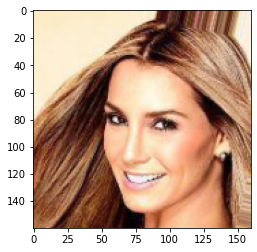

In [175]:
train_features, file_names = next(iter(celeba_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = transforms.ToPILImage()(train_features[0])
print(f'Filenanme: {file_names[0]}')
plt.imshow(img)
plt.show()

## Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The MTCNN forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have MTCNN return all detected faces, set keep_all=True when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level mtcnn.detect() function. See help(mtcnn.detect) for details.

In [176]:
aligned = []
face_file_names = []

for x, y in zip(train_features, file_names):
    img = transforms.ToPILImage()(x)
    x_aligned, prob = mtcnn(img, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        face_file_names.append(y)
    else: 
        print(f'No face detected for image: {y}')        

No face detected for image: 000120.jpg


In [177]:
# Get list of labels for the current batch
batch_labels = file_label_mapping[file_label_mapping['file_name'].isin(face_file_names)]['person_id'].to_numpy()

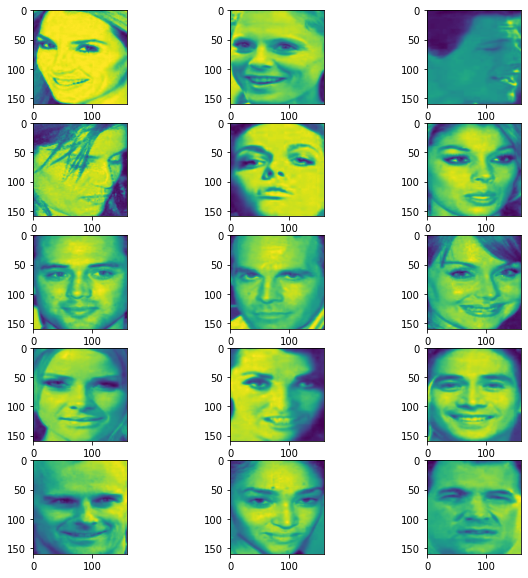

In [178]:
fig, axes = plt.subplots(nrows=5, ncols=3)  # set up a 5x3 grid to visualize
image_crop_list = [x[0] for x in aligned]
for img, ax in zip(image_crop_list, axes.ravel()):
    ax.imshow(img)
plt.gcf().set_size_inches(10, 10)

##Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [179]:
print(len(aligned))
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned)

127


## Print distance matrix for images

In [180]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
dists_df = pd.DataFrame(dists, columns=batch_labels, index=batch_labels)
dists_df = dists_df.loc[:,~dists_df.columns.duplicated()].copy()
dists_df

,2880,2937,8692,5805,9295,4153,9040,6369,3332,612,...,6938,9605,3705,999,6892,7541,4225,206,7018,4963
2880,0.000000,1.458055,1.472984,1.278388,1.287802,1.296722,1.496150,1.410818,1.360513,1.198140,...,1.383964,1.365681,1.393659,1.380620,1.314031,1.241243,1.448495,1.273215,1.415069,1.659607
2937,1.458055,0.000000,1.383640,1.442606,1.311064,1.343143,1.387660,1.344493,1.248464,1.319372,...,1.386616,1.497799,1.588524,1.325662,1.441129,1.394859,1.187226,1.476484,1.408029,1.219368
8692,1.472984,1.383640,0.000000,1.391899,1.535512,1.418274,1.374956,1.385999,1.608039,1.509573,...,1.517044,1.435473,1.354432,1.557879,1.340522,1.280431,1.450157,1.472816,1.382671,1.359027
5805,1.278388,1.442606,1.391899,0.000000,1.427541,1.391111,1.423611,1.479977,1.529655,1.408989,...,1.215499,1.549440,1.306527,1.543579,1.375406,1.247833,1.442646,1.347746,1.418175,1.457826
9295,1.287802,1.311064,1.535512,1.427541,0.000000,1.178927,1.383761,1.422666,1.247296,1.393869,...,1.288053,1.491298,1.373427,1.398770,1.347721,1.361388,1.466226,1.419470,1.357314,1.393435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,1.241243,1.394859,1.280431,1.247833,1.361388,1.375599,1.525179,1.466577,1.450240,1.386261,...,1.541936,1.602187,0.974027,1.398590,1.384945,0.000000,1.382012,1.560023,1.275401,1.380614
4225,1.448495,1.187226,1.450157,1.442646,1.466226,1.566330,1.457511,1.279828,1.325045,1.307486,...,1.454664,1.412125,1.448105,1.439148,1.484652,1.382012,0.000000,1.336529,1.445710,1.506822
206,1.273215,1.476484,1.472816,1.347746,1.419470,1.392965,1.308155,1.473158,1.348979,1.145549,...,1.220996,1.380736,1.436072,1.481037,1.535064,1.560023,1.336529,0.000000,1.495738,1.623188
7018,1.415069,1.408029,1.382671,1.418175,1.357314,1.230714,1.319353,1.333887,1.616562,1.520346,...,1.525897,1.542012,1.324533,1.363900,1.490096,1.275401,1.445710,1.495738,0.000000,1.536886


# Compare new Image

person_id: 5107
Face detected with probability: 0.999999


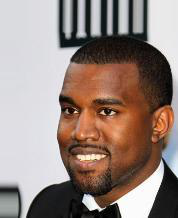

In [188]:
# Open the image form working directory
test_image_file_name = '004635.jpg'
test_image = Image.open(test_image_file_name)

test_image_person_id = file_label_mapping[file_label_mapping['file_name'] == test_image_file_name]['person_id'].values[0]
print(f'person_id: {test_image_person_id}')

# Detect face in test image
aligned_test_image, prob = mtcnn(test_image, return_prob=True)
print('Face detected with probability: {:8f}'.format(prob))

test_image

In [182]:
# Calculate Embeddings for Test Image
aligned_test_image = aligned_test_image.reshape([1] + list(aligned_test_image.shape)).to(device)
test_image_embedding = resnet(aligned_test_image)

In [183]:
# Calculate Distances to Train Dataset
embeddings = embeddings.to(device)
dists = [(test_image_embedding - e1).norm().item() for e1 in embeddings]
dists_df = pd.DataFrame(dists, columns=['test_image'], index=face_file_names)
dists_df = abs(dists_df - 1)

# Find closest embedding
display(dists_df[dists_df['test_image'] == dists_df['test_image'].min()])
closest_image = dists_df[dists_df['test_image'] == dists_df['test_image'].min()].index.values[0]

,test_image
000037.jpg,0.112285


In [187]:
display(dists_df[dists_df['test_image'] == dists_df['test_image']])

,test_image
000001.jpg,0.516917
000002.jpg,0.519488
000003.jpg,0.490784
000004.jpg,0.451513
000005.jpg,0.407071
...,...
000124.jpg,0.340615
000125.jpg,0.511086
000126.jpg,0.574753
000127.jpg,0.367409


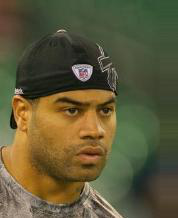

In [184]:
# Open the closest image form working directory
closest_image = Image.open(f'img_align_celeba/{closest_image}')
closest_image

# Whole Dataset Operations

After the above example, we load a large number of images and create embeddings for them. Then, we compare these with a test set to get a baseline accuracy based on the smallest euclidean distance.

## Load data

In [ ]:
load_new_data = False
file_number_to_load = '028289'
num_batches = 220

In [160]:
# Custom data loading function

def load_data(dataloader: torch.utils.data.DataLoader, num_batches: int):
    embeddings = None
    face_file_names = []

    for idx, batch in enumerate(dataloader):
        aligned = torch.tensor([])
        train_features, file_names = batch

        for train_feature, file_name in zip(train_features, file_names):
            img = transforms.ToPILImage()(train_feature)
            feature_aligned, prob = mtcnn(img, return_prob=True)
            if feature_aligned is not None:
                feature_aligned = feature_aligned.reshape([1, 3, image_size, image_size])
                face_file_names.append(file_name)
                if len(aligned) == 0:
                    aligned = feature_aligned
                else:
                    aligned = torch.cat([aligned, feature_aligned])

        print(f'Batch {idx}. Batch shape: {aligned.shape}')
        aligned = aligned.to(device)
        batch_embeddings = resnet(aligned).detach().cpu()

        if embeddings == None:
            embeddings = batch_embeddings
        else:
            embeddings = torch.cat([embeddings, batch_embeddings])

        if idx == num_batches:
            break

    return embeddings, face_file_names

if load_new_data:
    train_embeddings, train_face_file_names = load_data(celeba_dataloader, num_batches)
    torch.save(train_embeddings, f'pytorch_objects/embeddings_up_to_img_{face_file_names[-1][0:-4]}.pickle')
    with open(f'pytorch_objects/file_names_up_to_img_{face_file_names[-1][0:-4]}', 'w') as fp:
        for item in face_file_names:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')
else:
    train_embeddings = torch.load(f'pytorch_objects/embeddings_up_to_img_{file_number_to_load}.pickle')
    train_face_file_names = []
    with open(f'pytorch_objects/file_names_up_to_img_{file_number_to_load}', 'r') as fp:
        for line in fp:
            x = line[:-1]
            # add current item to the list
            train_face_file_names.append(x)


print(train_embeddings.shape)

torch.Size([28246, 512])


In [161]:
train_labels = file_label_mapping[file_label_mapping['file_name'].isin(train_face_file_names)]['person_id'].values
print(f'Number of people in train dataset: {len(np.unique(train_labels))}')

Number of people in train dataset: 7390


In [144]:
test_embeddings, test_face_file_names = load_data(celeba_test_dataloader, 10)

# Get labels for test dataset from mapping dataframe
test_labels = list(file_label_mapping[file_label_mapping['file_name'].isin(test_face_file_names)]['person_id'].values)

Batch 0. Batch shape: torch.Size([128, 3, 160, 160])
Batch 1. Batch shape: torch.Size([128, 3, 160, 160])
Batch 2. Batch shape: torch.Size([15, 3, 160, 160])
torch.Size([271, 512])


## Make Predictions

In [ ]:
def predict(test_embeddings: torch.tensor, train_embeddings: torch.tensor, file_label_mapping):
    # Calculate distance for the test dataset and calculate accuracy
    accuracy = 0
    predictions = []
    predictions_files = []
    test_set_size = len(test_embeddings)
    
    for idx, test_embedding in enumerate(test_embeddings):
        dists = [(test_embedding - e1).norm().item() for e1 in train_embeddings]
        closest_image_file_name = face_file_names[np.argmin(dists)]
        predicted_person_id = file_label_mapping[file_label_mapping['file_name'] == closest_image_file_name]['person_id'].values[0]

        predictions.append(predicted_person_id)
        predictions_files.append(closest_image_file_name)

    return predictions, predictions_files

test_predictions, test_predictions_files = predict(test_embeddings, train_embeddings, file_label_mapping)

In [163]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {np.round(accuracy, 4)}')

Accuracy: 0.8007


## Analyze misclassifications

In [138]:
# Get falsely predicted image files
def get_false_predictions_file_names(predictions, labels, file_names):
    false_predictions_files = []
    true_images_of_false_predictions_files = []
    for idx, (y_hat, y) in enumerate(zip(predictions, labels)):
        if y_hat != y:
            true_images_of_false_predictions_files.append(file_names[idx])
            false_predictions_files.append(test_predictions_files[idx])

    return true_images_of_false_predictions_files, false_predictions_files

true_images_of_false_predictions_files, false_predictions_files = get_false_predictions_file_names(test_predictions, test_labels, test_face_file_names)

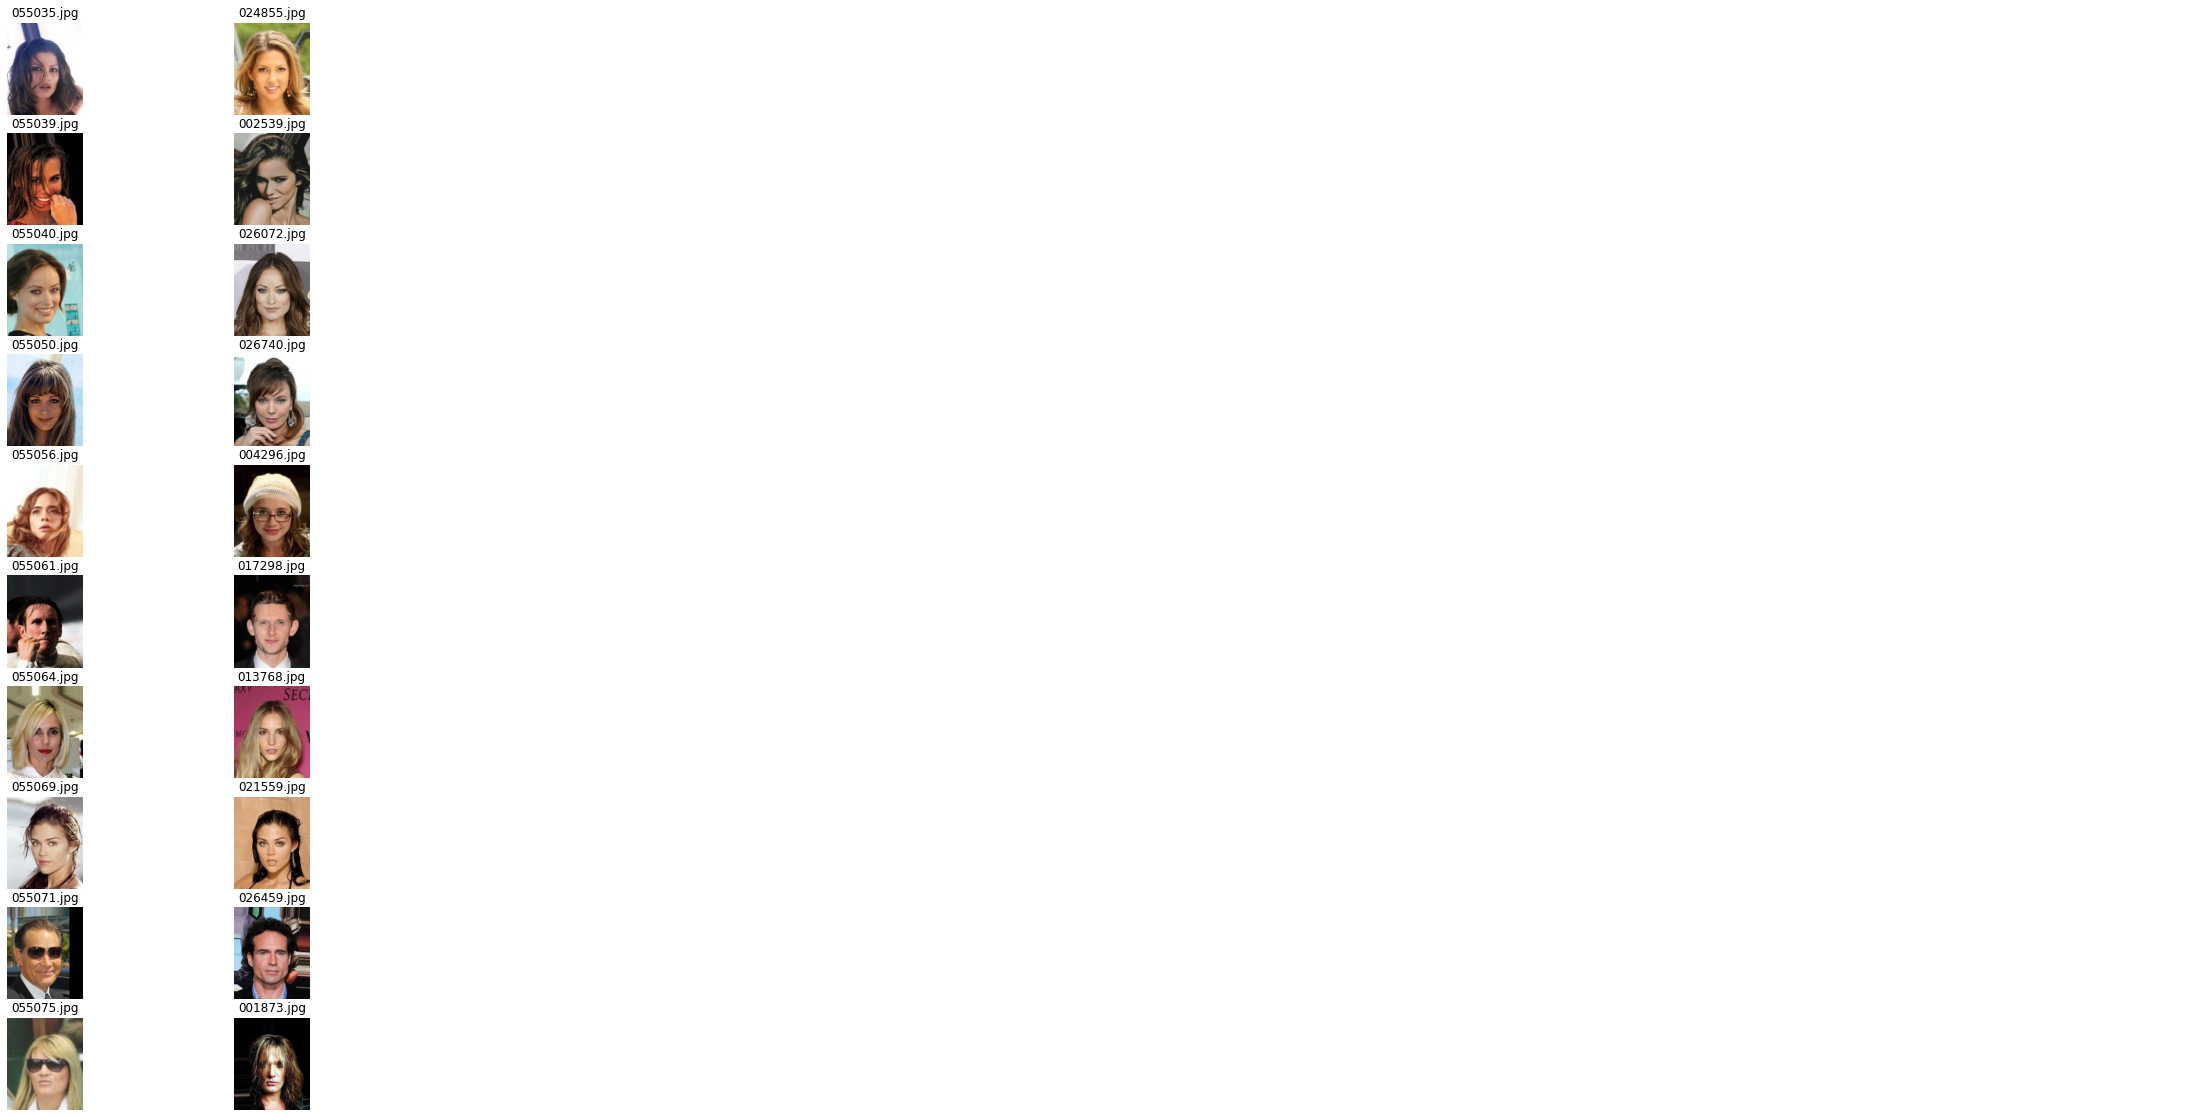

In [148]:
# Get sample images of false predictions

n = 10
fig, axs = plt.subplots(n, 10)

# remove axis for every image
for row in axs:
    for ax in row:
        ax.axis('off')

# display image
for i, (true_img_name, pred_img_name)  in enumerate(zip(true_images_of_false_predictions_files, false_predictions_files)):
    
    # calculate position
    col = 0
    row = i

    # read image
    true_img = plt.imread(f'test_img/{true_img_name}')
    pred_img = plt.imread(f'img_align_celeba/{pred_img_name}')
    
    # display image
    axs[i][0].imshow(true_img)
    axs[i][1].imshow(pred_img)

    # add title with filename without directory
    axs[i][0].set_title(true_img_name)
    axs[i][1].set_title(pred_img_name)

    if i == n-1:
        break
    
plt.gcf().set_size_inches(n*4, 20)
plt.show()